In [1]:
import torch

from plot import *
from constants import MEANS, STDS
from maths import me, mae, rmse
from fft import *

In [2]:
VARIABLE = "U"

LAT_RESOLUTION = 361
LON_RESOLUTION = 576
TIME_RESOLUTION = 8 * 365

if VARIABLE == "U":
    model = torch.load("FNN/U-1024-512-256-LeakyReLU-NGCTCC-hardy-bee-540")
else:
    model = torch.load("FNN/V-1024-512-256-LeakyReLU-NGCTCC-radiant-wave-1")
model.eval()

Sequential(
  (0): Linear(in_features=19, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
def get_model_inputs(df):
    df["lat_i"] = (df["lat"] + 90) // 0.5
    df["lon_i"] = (df["lon"] + 180) // 0.625

    df["lat"] /= 90
    df["lon"] /= 180
    df["lev"] /= 36

    df["day %"] = (df["time"] % 8) / 8
    df["year %"] = (df["time"] / 2920).astype("float16")
    del df["time"]

    df["sin_day"] = np.sin(df["day %"] * np.pi * 2)
    df["cos_day"] = np.cos(df["day %"] * np.pi * 2)
    df["sin_year"] = np.sin(df["year %"] * np.pi * 2)
    df["cos_year"] = np.cos(df["year %"] * np.pi * 2)

    df["sin_lat"] = np.sin(df["lat"] * np.pi)
    df["cos_lat"] = np.cos(df["lat"] * np.pi)
    df["sin_lon"] = np.sin(df["lon"] * np.pi)
    df["cos_lon"] = np.cos(df["lon"] * np.pi)

    frland = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLAND",
                                             time=0, level=0, folder="../data/raw").astype("float16")
    frocean = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FROCEAN",
                                              time=0, level=0, folder="../data/raw").astype("float16")
    frlake = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLAKE",
                                             time=0, level=0, folder="../data/raw").astype("float16")
    frlandice = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLANDICE",
                                                time=0, level=0, folder="../data/raw").astype("float16")
    phis = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="PHIS",
                                           time=0, level=0, folder="../data/raw")
    sgh = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="SGH",
                                          time=0, level=0, folder="../data/raw")

    phis -= phis.mean()
    phis /= phis.std()
    phis = phis.astype("float16")

    sgh -= sgh.mean()
    sgh /= sgh.std()
    sgh = sgh.astype("float16")

    indices = df[["lat_i", "lon_i"]].values.T.astype("int16")
    del df["lat_i"], df["lon_i"]

    df["frland"] = frland[*indices]
    df["frocean"] = frocean[*indices]
    df["frlake"] = frlake[*indices]
    df["frlandice"] = frlandice[*indices]
    df["phis"] = phis[*indices]
    df["sgh"] = sgh[*indices]

    return df

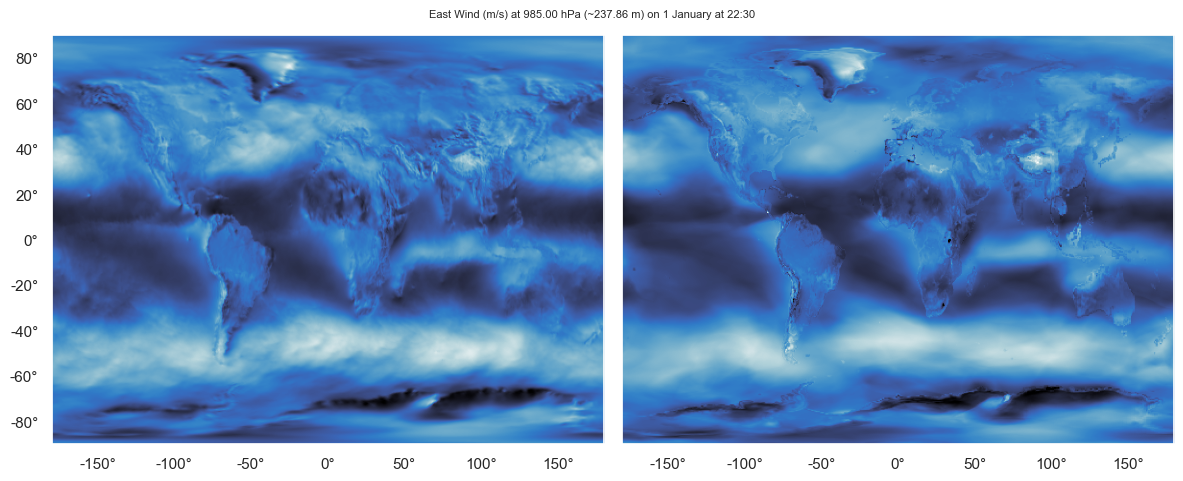

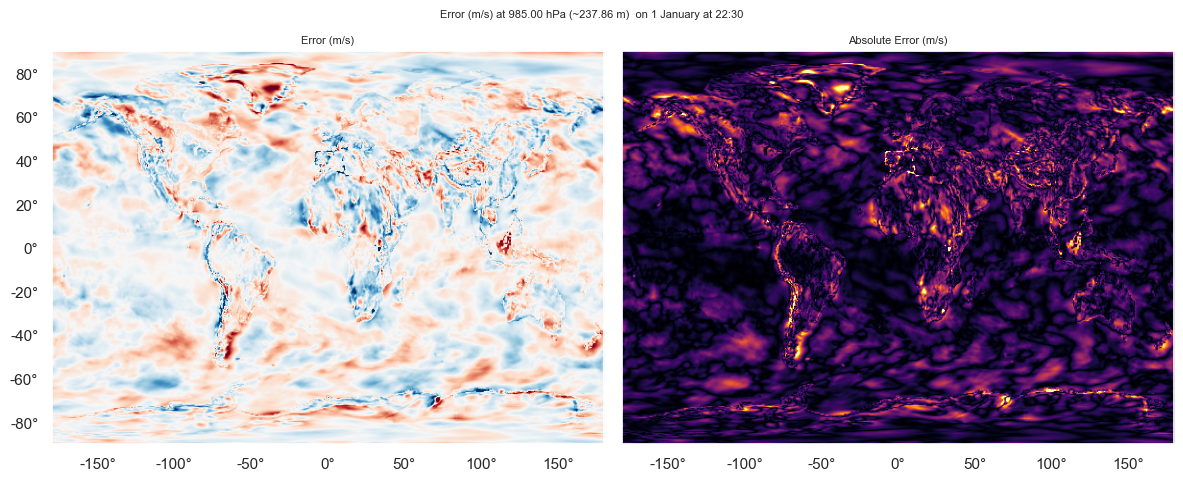

In [66]:
def plot_prediction_contour(filename, time, lev, prediction=None, plot_error=True):
    data = load_variable_at_time_and_level(filename, VARIABLE, time, lev, folder="../data")

    lat, lon = np.meshgrid(np.linspace(-90, 90, LAT_RESOLUTION, endpoint=False),
                           np.linspace(-180, 180, LON_RESOLUTION, endpoint=False))
    lat = lat.flatten()
    lon = lon.flatten()

    df = pd.DataFrame({"lev": lev, "lat": lat, "lon": lon, "time": time}, dtype="float16")
    df = get_model_inputs(df)

    if prediction is None:
        with torch.no_grad():
            prediction = np.array(model(torch.tensor(df.values, dtype=torch.float32, device="mps")).cpu())
        prediction = prediction.reshape((LON_RESOLUTION, LAT_RESOLUTION)).T * STDS[VARIABLE] + MEANS[VARIABLE]

    title = f"{format_variable(VARIABLE)} at {format_level(lev)}" \
            f" on {format_date(filename)} at {format_time(time, filename)}"

    fig, ax1, ax2 = create_1x2_plot(title, sharey=True, sharex=True)
    vmin, vmax = get_vmin_and_vmax(data, 0)
    ax1.imshow(data, cmap=cmr.arctic, origin="lower", extent=[-180, 180, -90, 90], aspect="auto", vmin=vmin, vmax=vmax)
    ax2.imshow(prediction, cmap=cmr.arctic, origin="lower", extent=[-180, 180, -90, 90], aspect="auto", vmin=vmin, vmax=vmax)

    ax1.grid(False)
    ax2.grid(False)

    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d°"))
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d°"))

    fig.suptitle(title, fontsize=8, y=0.96)

    if not plot_error:
        return

    title = f"Error ({get_units_from_variable(VARIABLE)}) at {format_level(lev)} " \
            f" on {format_date(filename)} at {format_time(time, filename)}"

    error = data - prediction

    fig, ax1, ax2 = create_1x2_plot(title, sharey=True, sharex=True)

    vmin, vmax = get_vmin_and_vmax(error, 0.001)
    ax1.imshow(error, cmap="RdBu", origin="lower", extent=[-180, 180, -90, 90], aspect="auto", vmin=vmin, vmax=vmax)
    ax2.imshow(np.abs(error), cmap="inferno", origin="lower", extent=[-180, 180, -90, 90], aspect="auto", vmin=0, vmax=vmax)

    ax1.grid(False)
    ax2.grid(False)

    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d°"))
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d°"))

    fig.suptitle(title, fontsize=8, y=0.96)
    ax1.set_title("Error (m/s)", fontsize=8)
    ax2.set_title("Absolute Error (m/s)", fontsize=8)


plot_prediction_contour("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", time=7, lev=35)

In [57]:
def predict_at_level(lev: int):
    predictions = []

    lat, lon = np.meshgrid(np.linspace(-90, 90, LAT_RESOLUTION, endpoint=False),
                           np.linspace(-180, 180, LON_RESOLUTION, endpoint=False))
    lat = lat.flatten()
    lon = lon.flatten()

    df = pd.DataFrame({"lev": lev, "lat": lat, "lon": lon, "time": 0}, dtype="float16")
    df = get_model_inputs(df)

    for time in tqdm(range(0, 8 * 365)):
        df["day %"] = (time % 8) / 8
        df["year %"] = time / 2920

        df["sin_day"] = np.sin(df["day %"] * np.pi * 2)
        df["cos_day"] = np.cos(df["day %"] * np.pi * 2)
        df["sin_year"] = np.sin(df["year %"] * np.pi * 2)
        df["cos_year"] = np.cos(df["year %"] * np.pi * 2)

        with torch.no_grad():
            prediction = model(torch.tensor(df.values, device="mps", dtype=torch.float32))
        prediction = np.array((prediction.reshape((LON_RESOLUTION, LAT_RESOLUTION)).T * STDS[VARIABLE] + MEANS[VARIABLE]).cpu(), dtype="float16")
        predictions.append(prediction)

    return np.array(predictions)


LEVEL = 35

predictions = predict_at_level(LEVEL)

  0%|          | 0/2920 [00:00<?, ?it/s]

In [60]:
filename = "MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4"
data = load_variable_at_level(filename, VARIABLE, LEVEL, folder="../data")

error = data - predictions

lines = f"""
    Original Stdev: {data.astype('float32').std()} m/s
    Predicted ME:  {me(data, predictions)} m/s
    Predicted MAE:  {mae(data, predictions)} m/s
    Predicted RMSE: {rmse(data, predictions)} m/s
"""
print(lines)

  0%|          | 0/12 [00:00<?, ?it/s]


    Original Stdev: 4.529156684875488 m/s
    Predicted ME:  0.00848388671875 m/s
    Predicted MAE:  0.96826171875 m/s
    Predicted RMSE: 1.2967808700779018 m/s



In [61]:
error_fft = dft3_at_level(error, LEVEL, quantile=0.999, cache=False)
error_prediction, error_freqs = idft3_at_level(*error_fft)

fft = dft3_at_level(data, LEVEL, quantile=0.999, cache=False)
dft_prediction, dft_freqs = idft3_at_level(*fft)

corrected_pred = predictions + error_prediction

lines = f"""
    Fourier Size: {sum(el.nbytes for el in fft) * 36 / (1000 ** 2)} MB
    Fourier ME:  {me(data, dft_prediction)} m/s
    Fourier MAE:  {mae(data, dft_prediction)} m/s
    Fourier RMSE: {rmse(data, dft_prediction)} m/s

    Corrected Size: {sum(el.nbytes for el in error_fft) * 36 / (1000 ** 2) + 14.6} MB
    Corrected ME:  {me(data, corrected_pred)} m/s
    Corrected MAE:  {mae(data, corrected_pred)} m/s
    Corrected RMSE: {rmse(data, corrected_pred)} m/s
    """
print(lines)


    Fourier Size: 44.5248 MB
    Fourier ME:  -1.1535398250150367e-06 m/s
    Fourier MAE:  0.36932209624443063 m/s
    Fourier RMSE: 0.4895701581762747 m/s

    Corrected Size: 59.504204 MB
    Corrected ME:  -5.363996538939997e-07 m/s
    Corrected MAE:  0.45235938575429735 m/s
    Corrected RMSE: 0.6126882608687174 m/s
    


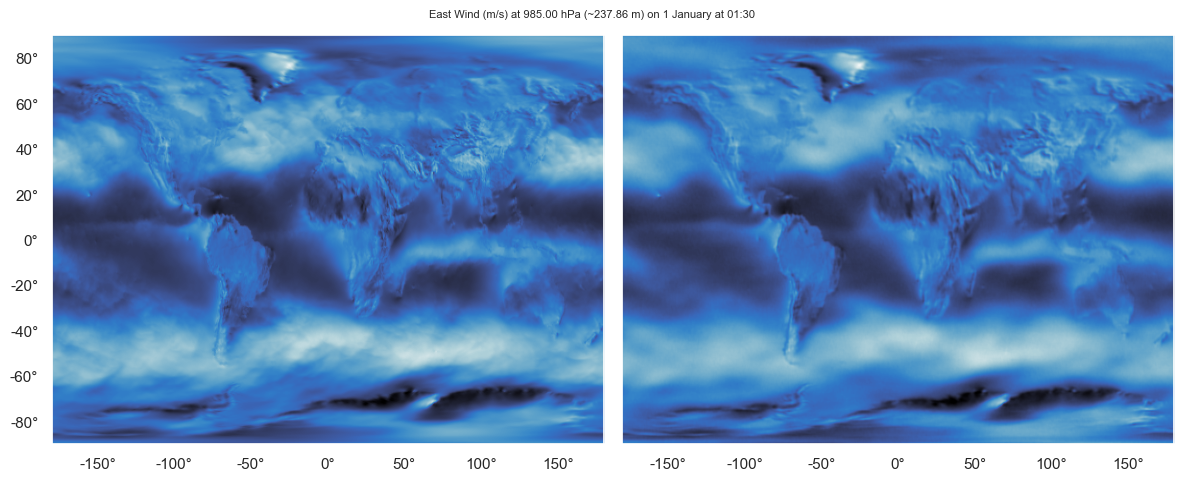

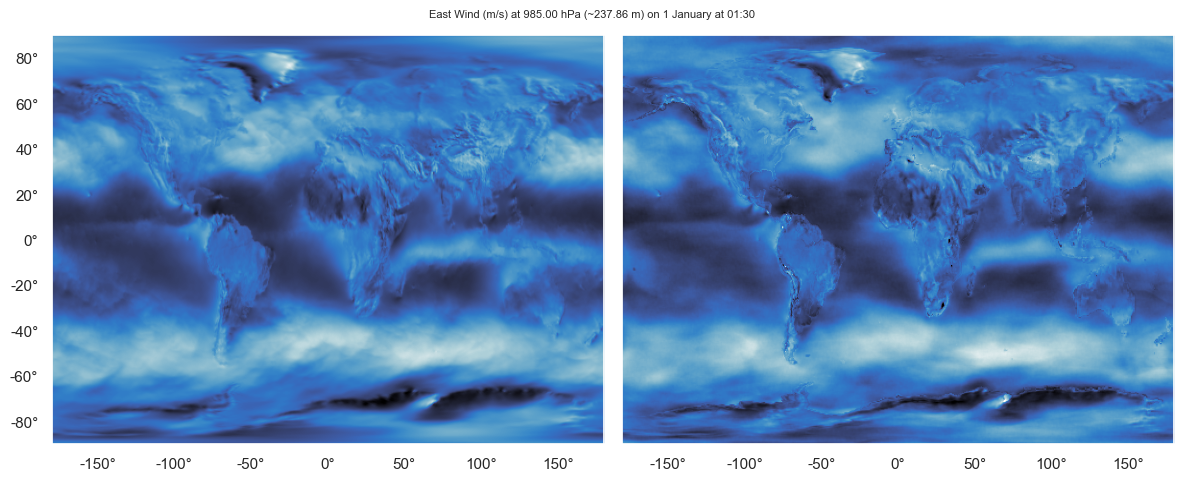

In [71]:
plot_prediction_contour("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", time=0, lev=35, prediction=dft_prediction[0], plot_error=False)
plt.show()
plot_prediction_contour("MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4", time=0, lev=35, prediction=corrected_pred[0], plot_error=False)

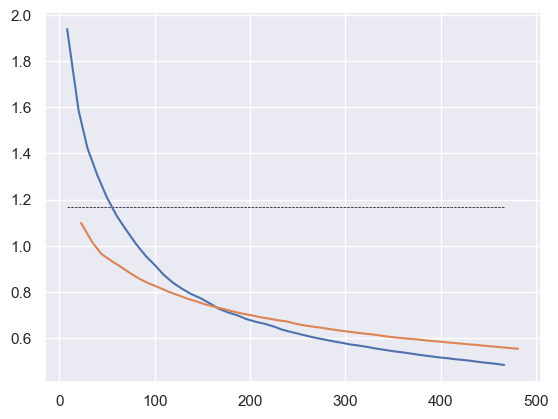

In [29]:
from fft import dft2_at_time_and_level, idft2_at_time_and_level

mlp_errors = [np.abs(prediction - data).mean()] * 50

dft_errors = []
dft_sizes = []
mlp_dft_errors = []
mlp_dft_sizes = []

quantiles = np.linspace(0.99, 0.9999, 50)

for quantile in quantiles:
    fft = dft2_at_time_and_level(error, quantile=quantile)
    error_prediction, _ = idft2_at_time_and_level(*fft)

    fft = dft2_at_time_and_level(data, quantile=quantile)
    dft_prediction, freqs = idft2_at_time_and_level(*fft)

    corrected_pred = prediction + error_prediction

    dft_errors.append(np.abs(dft_prediction - data).mean())
    mlp_dft_errors.append(np.abs(corrected_pred - data).mean())
    dft_sizes.append(sum(el.nbytes for el in fft) * 36 * 8 * 365 / (1000 ** 2))
    mlp_dft_sizes.append(sum(el.nbytes for el in fft) * 36 * 8 * 365 / (1000 ** 2) + 5.2)

plt.plot(dft_sizes, mlp_errors, c="#000", linestyle="dashed", linewidth=0.5)
plt.plot(dft_sizes, dft_errors)
plt.plot(mlp_dft_sizes, mlp_dft_errors)